<a href="https://colab.research.google.com/github/XPE-7/Invezo/blob/main/stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance matplotlib scikit-learn tensorflow ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=640d71e9c23bec4d250c8482c0e1d20c086af2019e2e433a014317739f054525
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from ta import add_all_ta_features

stock = "GOOG"
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

In [3]:
stock = "GOOG"
end = datetime.now()
start = datetime(end.year - 20, end.month, end.day)

In [4]:
data = yf.download(stock, start, end)
data.reset_index(inplace=True)
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,GOOG,GOOG,GOOG,GOOG,GOOG
0,2005-03-16,4.352990,4.427605,4.338364,4.380257,285317446
1,2005-03-17,4.444461,4.453137,4.357947,4.390917,331662510
2,2005-03-18,4.463053,4.471977,4.420168,4.432562,284663002
3,2005-03-21,4.483876,4.515854,4.393891,4.443965,300470030
4,2005-03-22,4.427357,4.510153,4.408765,4.491313,226112360


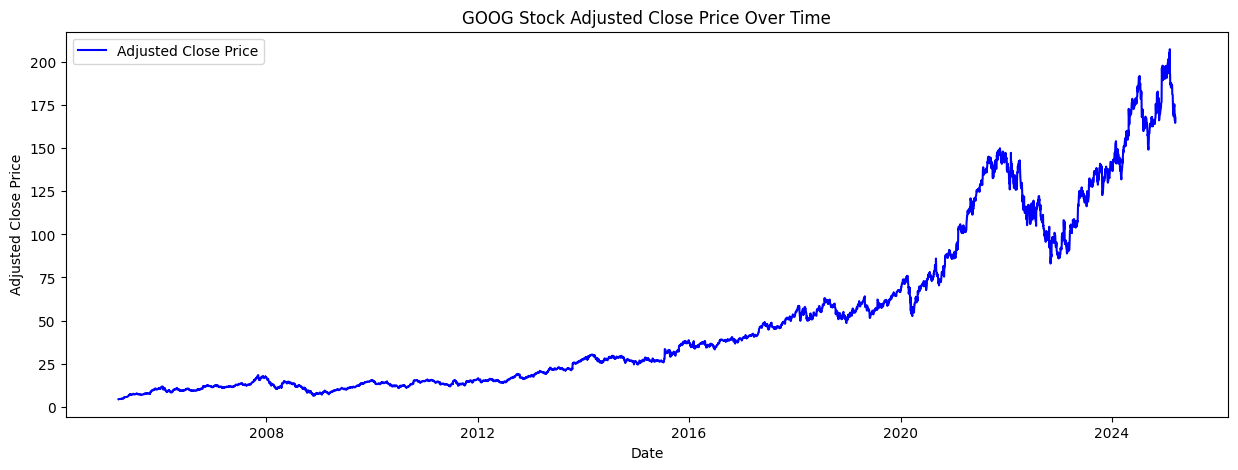

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(data['Date'], data['Close'], label='Adjusted Close Price', color='blue') # Changed 'Adj Close' to 'Close'
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'{stock} Stock Adjusted Close Price Over Time')
plt.legend()
plt.show()

In [6]:
scaled_data = data[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(scaled_data)

In [7]:
training_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:training_size], scaled_data[training_size:]

In [8]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [9]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [10]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0044 - val_loss: 8.5043e-04
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 2.5029e-04 - val_loss: 9.0315e-04
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 2.4303e-04 - val_loss: 0.0016
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 2.2469e-04 - val_loss: 7.6896e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.6236e-04 - val_loss: 0.0024
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 2.0128e-04 - val_loss: 6.4054e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.7916e-04 - val_loss: 9.1889e-04
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 1.5719e-04 - val_loss: 0.0011
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.8401e-04 - val_loss: 9.5109e-04
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 1.3816e-04 - val_loss: 0.0012
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 1.316

In [12]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


In [13]:
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 3.48339496675113


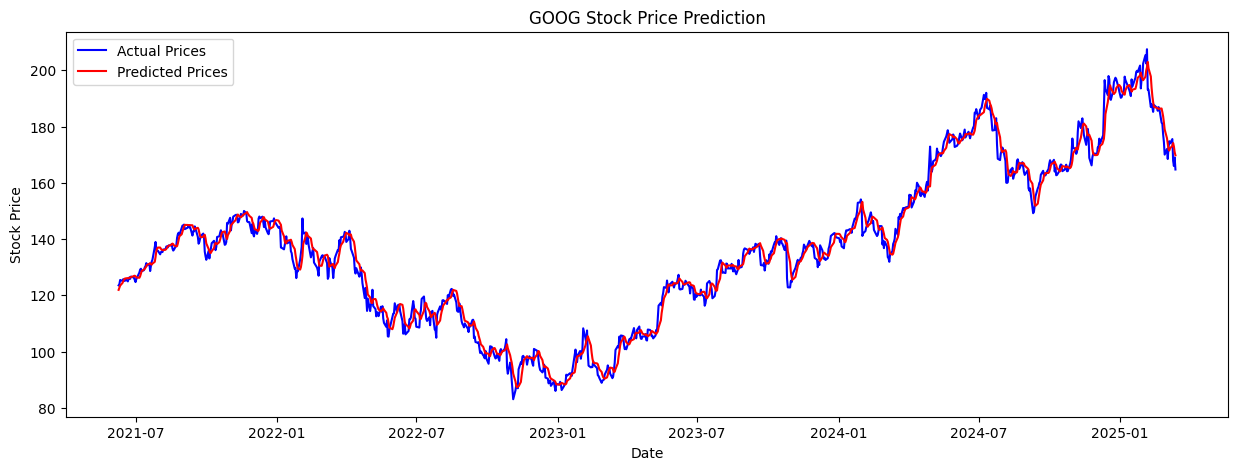

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(data['Date'][-len(actual_prices):], actual_prices, label='Actual Prices', color='blue')
plt.plot(data['Date'][-len(predicted_prices):], predicted_prices, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'{stock} Stock Price Prediction')
plt.legend()
plt.show()

In [15]:
model.save('stock_mode.h5')